# User-Interface for Res-IRF
The Res-IRF model is a tool for simulating energy consumption for space heating in the French residential sector.

Its main characteristic is to integrate a detailed description of the energy performance of the dwelling stock with a rich description of household behaviour.

This notebook is an example of post-treatment.

Variable used by this notebook:
- cost intangible (to be done)
- cost construction
- cost envelope
- stock segmented
- stock construction segmented
- consumption

In [1]:
import os

print(os.getcwd())
os.chdir(os.path.join(os.getcwd(), '..'))
print(os.getcwd())

/Users/lucas/PycharmProjects/Res-IRF/project
/Users/lucas/PycharmProjects/Res-IRF


In [2]:
import pickle
from ui_utils import *
import matplotlib.pyplot as plt

from parse_input import colors_dict

**User need to enter folder's name:**

In [3]:
# name_folder = '20210604_094019'
name_folder = os.path.join('20210610_191326')


# Reading input

In [4]:
folder_output = os.path.join(os.getcwd(), 'project', 'output', name_folder)
print('Output will be taken from: {}'.format(folder_output))
folder_output_pkl = os.path.join(folder_output, 'output_pkl')

folder_detailed = os.path.join(folder_output, 'detailed')
folder_detailed_pkl = os.path.join(folder_detailed, 'pkl')

var_list = [
    'cost_intangible',
    'cost_construction',
    'cost_envelope',
    'stock_segmented',
    'stock_construction_segmented'
]
var_dict = {}
for key in var_list:
    name_file = os.path.join(folder_output_pkl, '{}.pkl'.format(key))
    with open(name_file, 'rb') as handle:
        var_dict[key] = pickle.load(handle)
        print('Reading: {}'.format(name_file))
        
var_detailed_dict = [
    'consumption_actual',
    'consumption_conventional',
    'consumption_final',
    'flow_renovation_label_energy_dict',
    'energy_cash_flows',
    'energy_lcc',
    'energy_lcc_final',
    'policies_detailed',
    'policies_total',
    'capex_total',
    'energy_saving',
    'emission_saving',
    'energy_saving_lc',
    'emission_saving_lc'
]
for key in var_detailed_dict:
    name_file = os.path.join(folder_detailed_pkl, '{}.pkl'.format(key))
    with open(name_file, 'rb') as handle:
        var_dict[key] = pickle.load(handle)
        print('Reading: {}'.format(name_file))

       


Output will be taken from: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/output_pkl/cost_intangible.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/output_pkl/cost_construction.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/output_pkl/cost_envelope.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/output_pkl/stock_segmented.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/output_pkl/stock_construction_segmented.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/pkl/consumption_actual.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/pkl/consumption_conventional.pkl
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/pkl/consumption_final.pkl
Reading:

In [5]:
l = [f for f in os.listdir(folder_detailed) if f.split('_')[0] == 'result']
for f in l:
    name_file = os.path.join(folder_detailed, f)
    var_dict[f.split('.')[0]] = pd.read_csv(name_file, index_col=[0, 1, 2, 3, 4, 5, 6, 7], header=[0])
    print('Reading: {}'.format(name_file))

Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2023.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2022.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2020.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2021.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2025.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2019.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2024.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2026.csv
Reading: /Users/lucas/PycharmProjects/Res-IRF/project/output/20210610_191326/detailed/result_euro_2027.csv
Reading: /Users/lucas/PycharmProjects

## Initial dwelling stock

## Evolution of dwelling stock
Res-IRF considers stock dynamics. Buildings demolition, construction and renovation.

### Dwellings stocks by Energy performance

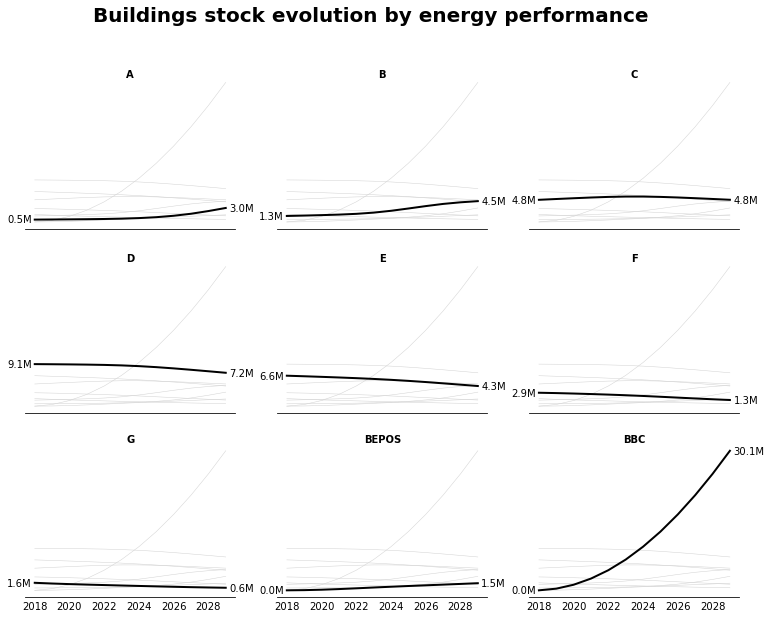

In [6]:
df = pd.concat((var_dict['stock_segmented'], var_dict['stock_construction_segmented']), axis=0)
df_ep = df.groupby(['Energy performance']).sum()
df_ep = df_ep.loc[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'BEPOS', 'BBC']]
economic_subplots(df_ep, 'Buildings stock evolution by energy performance',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000))

### Dwellings stocks by Heating energy

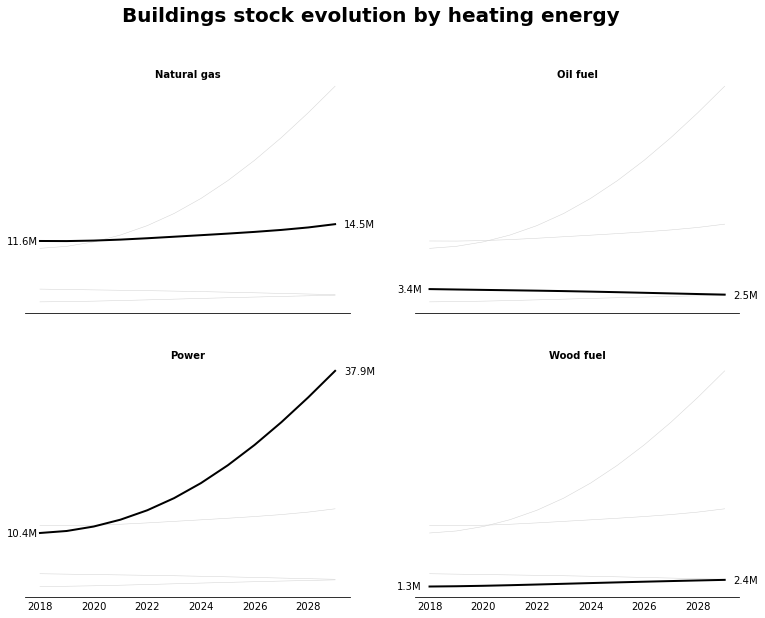

In [7]:
df_ep = df.groupby(['Heating energy']).sum()
economic_subplots(df_ep, 'Buildings stock evolution by heating energy',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.1f}M'.format(x / 1000000), n_columns=2)

### Renovation done

## Energy consumption
Thanks to renovation, demolition and construction, energy consumption tends to decrease over time in the reference case.
Energy consumption actual considers human behavior.

In [8]:
consumption_actual = var_dict['stock_segmented'] * var_dict['consumption_actual']
consumption_actual.dropna(axis=1, how='any', inplace=True)

In [9]:
consumption_actual

2018  \
Occupancy status Housing type  Energy performance Heating energy Income class Income class owner                  
Homeowners       Multi-family  A                  Natural gas    D1           D1                   25087.430876   
                                                                 D10          D10                 255039.183665   
                                                                 D2           D2                   50914.838266   
                                                                 D3           D3                   58852.375307   
                                                                 D4           D4                   74951.088395   
...                                                                                                         ...   
Social-housing   Single-family G                  Wood fuel      D5           D10                  24301.105949   
                                                                 D6           D10                  19525.960425   
                                                                 D7           D10                  15026.852883   
                                                                 D8           D10                  10111.189000   
                                                                 D9           D10                   5691.997352   

                                                                                                           2019  \
Occupancy status Housing type  Energy performance Heating energy Income class Income class owner                  
Homeowners       Multi-family  A                  Natural gas    D1           D1                   28202.511422   
                                                                 D10          D10                 294186.524087   
                                                                 D2           D2                   56034.240115   
                                                                 D3           D3                   65935.699598   
                                                                 D4           D4                   83589.771218   
...                                                                                                         ...   
Social-housing   Single-family G                  Wood fuel      D5           D10                  21780.316522   
                                                                 D6           D10                  17557.430519   
                                                                 D7           D10                  13488.495534   
                                                                 D8           D10                   9072.388002   
                                                                 D9           D10                   5098.088191   

                                                                                                           2020  \
Occupancy status Housing type  Energy performance Heating energy Income class Income class owner                  
Homeowners       Multi-family  A                  Natural gas    D1           D1                   31711.062261   
                                                                 D10          D10                 338953.885792   
                                                                 D2           D2                   61694.220252   
                                                                 D3           D3                   73780.728779   
                                                                 D4           D4                   93171.175918   
...                                                                                                         ...   
Social-housing   Single-family G                  Wood fuel      D5           D10                  19406.592743   
                                                                 D6           D1

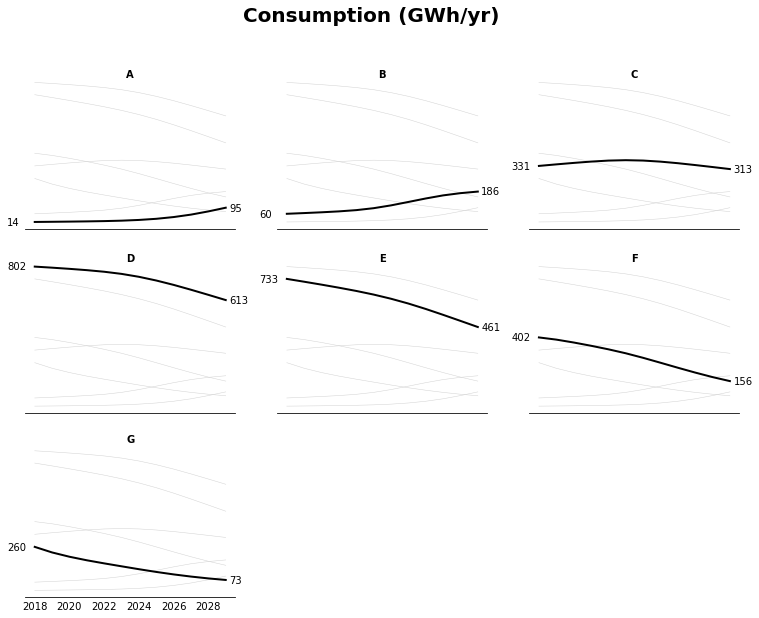

In [10]:
consumption_actual_ep = consumption_actual.groupby('Energy performance').sum()
economic_subplots(consumption_actual_ep, 'Consumption (GWh/yr)',
                  format_axtitle=lambda x: x, format_val=lambda x: '{:.0f}'.format(x / 1000000))

## Capex
Learning-by-doing and information acceleration tends to decrease transition costs.

### Renovation cost

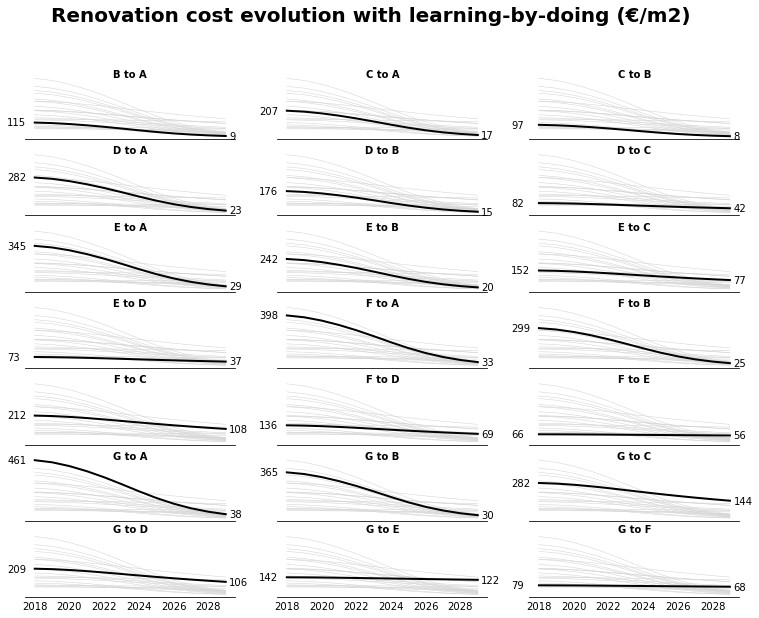

In [11]:
economic_subplots(var_dict['cost_envelope'], 'Renovation cost evolution with learning-by-doing (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

### Intangible cost

In [12]:
grouped_ep = var_dict['cost_intangible'].groupby(['Energy performance', 'Energy performance final'])
cost_intangible_ep = grouped_ep.mean()

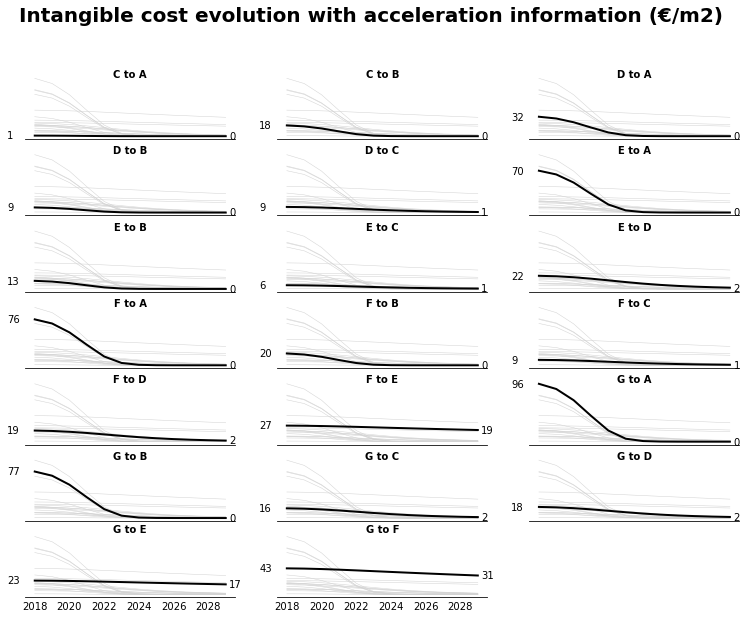

In [13]:
economic_subplots(cost_intangible_ep, 'Intangible cost evolution with acceleration information (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

In [14]:
# grouped_ep.boxplot(subplots=True)

### Construction cost

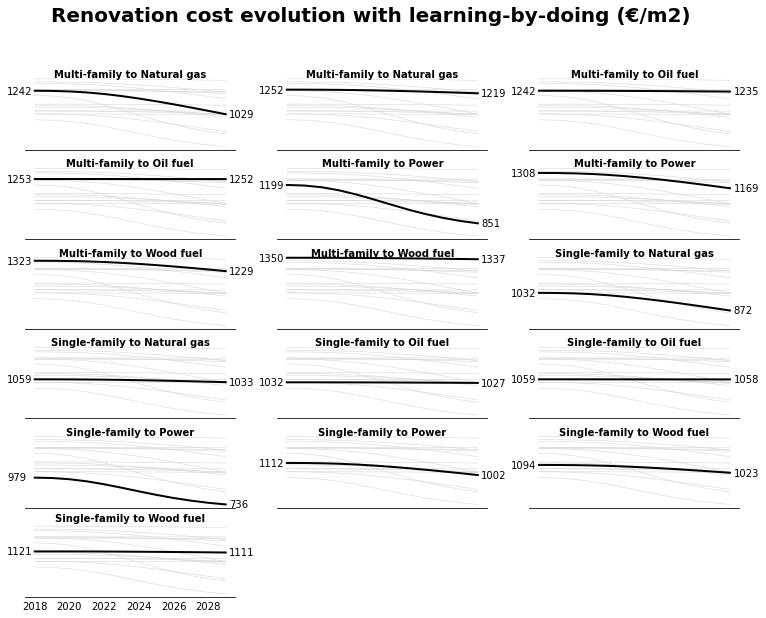

In [15]:
economic_subplots(var_dict['cost_construction'], 'Renovation cost evolution with learning-by-doing (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

## Total costs
Macro-economic costs: total investment, private investment and public investment.

In [16]:
data = pd.read_csv(os.path.join(folder_output, 'financials_dict.csv'), index_col=[0])
data.index

Index(['Consumption', 'Consumption construction', 'Consumption total',
       'Emission', 'Emission construction', 'Emission total',
       'Total number of renovations', 'Number of G & F buildings',
       'Investment macro', 'Private investment macro', 'Subsidies macro',
       'Energy taxes', 'Energy taxes construction', 'Energy taxes total',
       'Emission saving', 'Energy saving'],
      dtype='object')

In [17]:
# gCO2/yr --> tCO2/yr
data.loc['Emission saving', :] = data.loc['Emission saving', :] / 1000000
data.loc['Emission total', :] = data.loc['Emission total', :] / 1000000


# kWh/yr --> GWh/yr
data.loc['Energy saving', :] = data.loc['Energy saving', :] / 1000000
data.loc['Consumption total', :] = data.loc['Consumption total', :] / 1000000

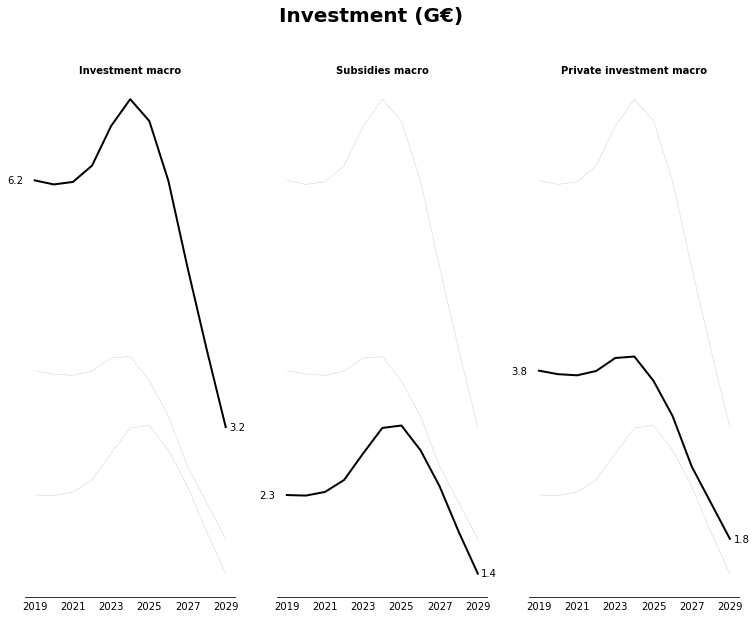

In [18]:
economic_subplots(data.loc[['Investment macro', 'Subsidies macro', 'Private investment macro',], :], 'Investment (G€)', format_val=lambda x: '{:.1f}'.format(x/1000000000))

### Subsidies

In [19]:
financials_unit = var_dict['result_unit_2019'] 
financials_euro = var_dict['result_euro_2019'] 

In [20]:
name_file = os.path.join(folder_detailed, 'policies_detailed.pkl')
with open(name_file, 'rb') as handle:
    subsidies_detailed = pickle.load(handle)

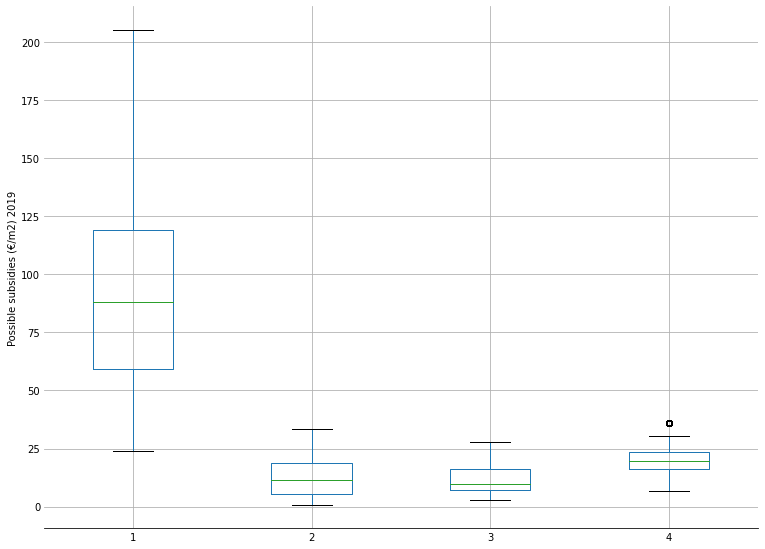

In [21]:
for yr in subsidies_detailed.keys():
    economic_boxplots(subsidies_detailed[yr], ylabel='Possible subsidies (€/m2) {}'.format(yr))
    break

In [22]:
a = subsidies_detailed[yr].index.names
subsidies_detailed[yr].index.names = a[:-1] + ['Energy performance final']

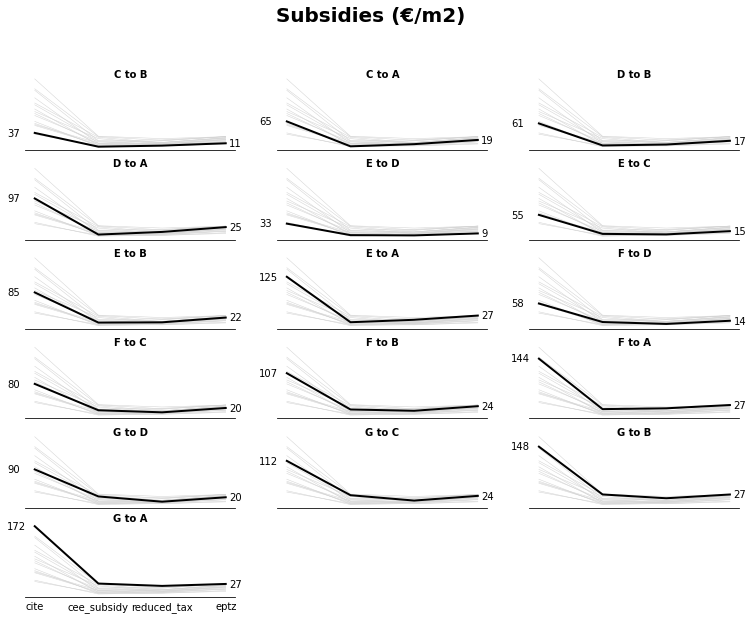

In [23]:
b = subsidies_detailed[yr].groupby(['Energy performance', 'Energy performance final']).mean()
economic_subplots(b, 'Subsidies (€/m2)',
                  format_axtitle=lambda x: '{} to {}'.format(x[0], x[1]), format_val=lambda x: '{:.0f}'.format(x))

### CO2 Cost

In [24]:
co2_graph = pd.DataFrame()
co2_graph['Flow renovation'] = financials_euro['Flow renovation'] * 100000
co2_graph['Emission saving'] = financials_euro['Emission saving'] / 100000
co2_graph['CO2 investment cost'] = financials_euro['CO2 investment cost'] * 100000
co2_graph['CO2 private cost'] = financials_euro['CO2 private cost'] * 100000
co2_graph = co2_graph.sort_values('CO2 private cost')
co2_graph['CO2 Potential Emission'] = co2_graph['Emission saving'].cumsum()

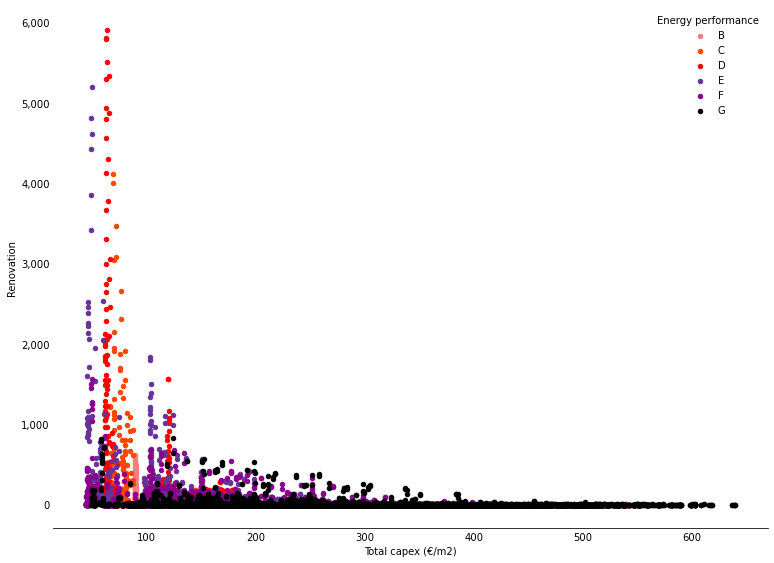

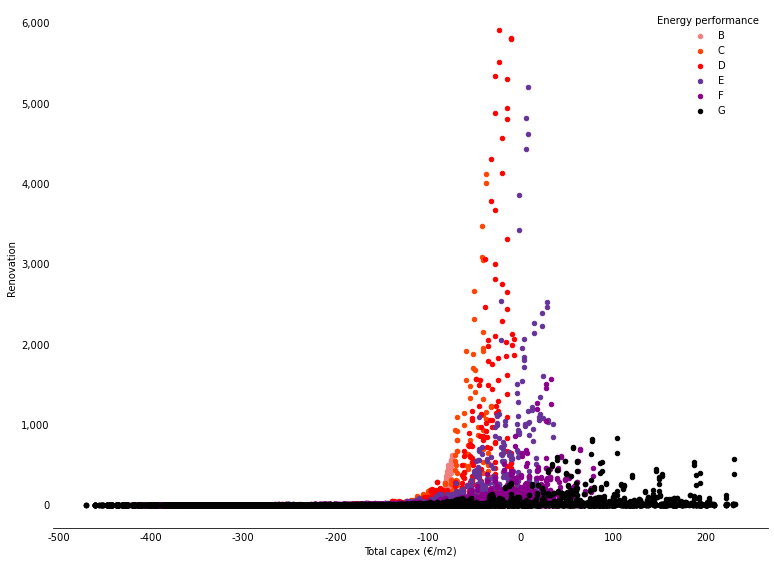

In [25]:
distribution_scatter(financials_unit, 'Total capex', 'Flow renovation', colors_dict,
                     xlabel='Total capex (€/m2)', ylabel='Renovation', level='Energy performance')

distribution_scatter(financials_unit, 'NPV', 'Flow renovation', colors_dict,
                     xlabel='Total capex (€/m2)', ylabel='Renovation', level='Energy performance')


# Objectives

1. Reduction of final energy consumption by 20% by 2030 and 50% by 2050 compared to 2012 - this objective is applied here to residential heating consumption;
2. Energy renovation of 500,000 homes per year, including 120,000 in social housing;
3. Disappearance of G and F energy performance housing by 2025;
4. Renovation of the entire housing stock to the "low-energy building" level or similar by 2050 - a requirement interpreted here as a minimum performance equal to the B label of the DPE;
5. Reducing fuel poverty by 15% by 2020.

In [26]:
main_result = pd.read_csv(os.path.join(folder_output, 'financials_dict.csv'), header=[0], index_col=[0])

In [27]:
main_result

,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029
Consumption,2.211178e+11,2.164499e+11,2.118413e+11,2.071030e+11,2.018306e+11,1.957142e+11,1.888733e+11,1.815401e+11,1.739797e+11,1.664484e+11,1.591668e+11
Consumption construction,6.184773e+08,2.071727e+09,4.308844e+09,7.258267e+09,1.083322e+10,1.496417e+10,1.964246e+10,2.487979e+10,3.069993e+10,3.715208e+10,4.431604e+10
Consumption total,2.217363e+11,2.185217e+11,2.161502e+11,2.143612e+11,2.126638e+11,2.106784e+11,2.085158e+11,2.064199e+11,2.046797e+11,2.036005e+11,2.034829e+11
Emission,4.168428e+13,4.043520e+13,3.921941e+13,3.799953e+13,3.669245e+13,3.524050e+13,3.367724e+13,3.205112e+13,3.041171e+13,2.880692e+13,2.727621e+13
Emission construction,9.532356e+10,3.178628e+11,6.582241e+11,1.104290e+12,1.642081e+12,2.260859e+12,2.960272e+12,3.743419e+12,4.615530e+12,5.586464e+12,6.671651e+12
Emission total,4.177961e+13,4.075306e+13,3.987763e+13,3.910382e+13,3.833453e+13,3.750136e+13,3.663751e+13,3.579453e+13,3.502724e+13,3.439338e+13,3.394786e+13
Total number of renovations,6.694489e+05,6.684810e+05,6.737902e+05,6.881286e+05,7.276670e+05,8.015771e+05,8.871868e+05,9.640976e+05,1.027055e+06,1.058701e+06,1.066219e+06
Number of G & F buildings,4.279509e+06,4.057031e+06,3.838975e+06,3.621091e+06,3.391044e+06,3.137619e+06,2.869288e+06,2.598692e+06,2.337094e+06,2.093478e+06,1.873839e+06
Investment macro,6.176819e+09,6.127416e+09,6.157994e+09,6.357682e+09,6.843021e+09,7.170639e+09,6.902767e+09,6.169545e+09,5.111281e+09,4.112131e+09,3.158924e+09
Private investment macro,3.849191e+09,3.806279e+09,3.792248e+09,3.845454e+09,4.004475e+09,4.022046e+09,3.724581e+09,3.293843e+09,2.677303e+09,2.234169e+09,1.792053e+09


# Interactive

### Interactive table

Interactive table that display information about a specific segment or segments (if multiple value passed).

Widget input:
(can choose one)
- df: financial_unit[year], financial_euro, segment
- yr: optional

(can choose multiple)
- Occupancy status: 
- Housing type: 
- Income class:
- Income class owner:
- Energy performance:
- Heating energy:
- Energy performance final:
- Heating energy final:

In [28]:
# TODO: if occ=None --> return all
def select_segment(df, occ='Homeowners', housing='Multi-family', income='D5', performance_ini='F', energy_ini='Oil fuel',
                   performance_end='C', energy_end='Oil fuel'):
    # TODO: if one level is not passed, function must returns dataframe. Use multilevels function in old notebook.
    if 'Energy performance final' not in df.index.names:
        return df.xs(occ, level='Occupancy status', drop_level=False).\
            xs(housing, level='Housing type', drop_level=False).\
            xs(income, level='Income class', drop_level=False).\
            xs(performance_ini, level='Energy performance', drop_level=False).\
            xs(energy_ini, level='Heating energy', drop_level=False)
    else:
        return df.xs(occ, level='Occupancy status', drop_level=False).\
            xs(housing, level='Housing type', drop_level=False).\
            xs(income, level='Income class', drop_level=False).\
            xs(performance_ini, level='Energy performance', drop_level=False).\
            xs(energy_ini, level='Heating energy', drop_level=False).\
            xs(performance_end, level='Energy performance final', drop_level=False).\
            xs(energy_end, level='Heating energy final', drop_level=False)


In [29]:
var_dict.keys()

dict_keys(['cost_intangible', 'cost_construction', 'cost_envelope', 'stock_segmented', 'stock_construction_segmented', 'consumption_actual', 'consumption_conventional', 'consumption_final', 'flow_renovation_label_energy_dict', 'energy_cash_flows', 'energy_lcc', 'energy_lcc_final', 'policies_detailed', 'policies_total', 'capex_total', 'energy_saving', 'emission_saving', 'energy_saving_lc', 'emission_saving_lc', 'result_euro_2023', 'result_euro_2022', 'result_euro_2020', 'result_euro_2021', 'result_euro_2025', 'result_euro_2019', 'result_euro_2024', 'result_euro_2026', 'result_euro_2027', 'result_unit_2020', 'result_unit_2021', 'result_unit_2023', 'result_unit_2022', 'result_unit_2026', 'result_unit_2027', 'result_unit_2025', 'result_unit_2019', 'result_unit_2024', 'result_unit_2029', 'result_unit_2028', 'result_euro_2029', 'result_euro_2028'])

In [30]:
output = concat_yearly_dict(var_dict)

In [31]:
output.keys()

dict_keys([])

In [32]:
data = output['flow_renovation_label_energy_dict']

KeyError: 'flow_renovation_label_energy_dict'

In [ ]:
data.index.names

In [ ]:
mux = pd.MultiIndex.from_arrays([
    list('aaaabbbbbccddddd'),
    list('tuvwtuvwtuvwtuvw')
], names=['Occupancy status', 'two'])

df = pd.DataFrame({'col': np.arange(len(mux))}, mux)

In [ ]:
df

In [ ]:
df.query("Occupancy status == 'a'")

In [ ]:
data

In [ ]:
# slicing with one argumnet
data.loc[['Landlords']]
data.xs('Landlords', level='Occupancy status', axis=0, drop_level=False)
data.query("`Occupancy status` == 'Landlords'")
idx = pd.IndexSlice
data.loc[idx[:, 'Multi-family', :, :, :, :, :, :], :]
data[data.index.get_level_values('Heating energy').isin(['Power', 'Natural gas'])]

items = ['Power', 'Natural gas']
data.query("`Heating energy` in @items")

data.query("`Occupancy status` == 'Landlords' and `Heating energy` in @items")


In [ ]:
# import plotly.graph_objects as go
from ipywidgets import widgets

In [ ]:
w_yrs = widgets.IntSlider(min=2018, max=2030, step=1, description='Years', disabled=False, continuous_update=False)
display(w_yrs)

In [ ]:
w = widgets.Checkbox(value=False, description='Check me', disabled=False, indent=False)
display(w)

In [ ]:
print(w.value)

In [ ]:
housing_type = widgets.Dropdown(options=['Landlords', 'Homeowners', 'Social-housing'], description='Housing type', disabled=False, layout={'width': 'max-content'})
display(housing_type)

In [ ]:
list_heating_energy = ['Power', 'Natural gas', 'Oil fuel', 'Wood fuel']
heating_energy = widgets.Dropdown(options=list_heating_energy, description='Heating energy', disabled=False, layout={'width': 'max-content'})
display(heating_energy)

In [ ]:
multiple = widgets.SelectMultiple(
    options=list_heating_energy,
    value=['Power'],
    description='Heating energy',
    disabled=False
)
display(multiple)

In [ ]:
multiple.value

### Interactive grouped

## Public policies

In [ ]:
Each year, how many subsidies have been given 

In [ ]:
import qgrid

In [ ]:
from itables import init_notebook_mode
from itables import show

# Sensitivity Analysis

Parameters sensitivy analysis:
- cost_invest
- cost_intangible
- nu 
- demolition_rate
- energy_prices 
- public_policies

Almost all need to make a new model calibration --> main_func need to be integrate calibration step
thread(main_func)
